In [98]:
using HDF5
using Plots
using LadderDGA
using Suppressor

path_to_input = "/home/julian/Hamburg/lDGA_shift_tests/data/20_20_s0_b12_u1.0"
path_to_output = "$(@__DIR__)/../../lDGA_test_runs"
cfg_file = "$(@__DIR__)/../../lDGA_test_runs/config.toml"
empty!(ARGS)
#push!(ARGS,path_to_input)
#push!(ARGS,path_to_output)
#include("../scripts/triqs_conv.jl")

String[]

Loading impurity quantities and constructing k grids.
removing the @supress block activates debugging output.

In [100]:
@suppress begin 
    mP, sP, env, kGrids, qGrids, qGridLoc, freqRed_map, freqList, freqList_min, parents, ops, nFermi, nBose, shift, base, offset = readConfig(cfg_file)
    kG = kGrids[1]
    qG = qGrids[1]
    νGrid, sumHelper_f, impQ_sp, impQ_ch, GImp_fft, GLoc_fft, Σ_loc, FUpDo, gImp, gLoc = setup_LDGA(kG, freqList, mP, sP, env);
end;

# Potential Issues

## Issue 1: Frequency fits impact tail of trilex

There seems to be some sort of error compensation when inverting $\Gamma$ and extrapolating the $\nu$ sum for $\chi$.

In [101]:
bubble = calc_bubble(νGrid, GLoc_fft, qG, mP, sP);

Internal code for the `calc_χ_trilex` function:

In [116]:
using SharedArrays
using Distributed
using GenericLinearAlgebra
using LinearAlgebra

# emulate function parameters and namespace
Γr = impQ_sp.Γ
U = mP.U
sum_freq = LadderDGA.sum_freq
sumHelper = sumHelper_f
kintegrate = LadderDGA.kintegrate
kGrid = qG
find_usable_interval = LadderDGA.find_usable_interval
sumHelper_ν_nc = LadderDGA.Naive()
sumHelper_ν_rc = LadderDGA.Richardson(LadderDGA.default_fit_range(size(bubble,3)), [0,1,2,3,4])
indh = ceil(Int64, size(bubble,1)/2)

# function starts here
χ_nc = SharedArray{eltype(bubble), 2}((size(bubble)[1:2]...))
γ_nc = SharedArray{eltype(bubble), 3}((size(bubble)...))
χ_rc = SharedArray{eltype(bubble), 2}((size(bubble)[1:2]...))
γ_rc = SharedArray{eltype(bubble), 3}((size(bubble)...))
γ_mix1 = SharedArray{eltype(bubble), 3}((size(bubble)...))
γ_mix2 = SharedArray{eltype(bubble), 3}((size(bubble)...))
χ_ω = SharedArray{eltype(bubble), 1}(size(bubble)[1]) 
ωindices = 1:size(bubble,1)
νIndices = 1:size(bubble,3);

In [117]:
# compute quantities
for ωi in ωindices
    Γview = view(Γr,ωi,νIndices,νIndices)
    UnitM = Matrix{eltype(Γr)}(I, length(νIndices),length(νIndices))
    for qi in 1:size(bubble, 2)
        bubble_i = view(bubble,ωi, qi, νIndices)
        bubbleD = Diagonal(bubble_i)
        χ_full = (bubbleD * Γview + UnitM)\bubbleD
        χ_nc[ωi, qi] = sum_freq(χ_full, [1,2], sumHelper_ν_nc, mP.β)[1,1]
        χ_rc[ωi, qi] = sum_freq(χ_full, [1,2], sumHelper_ν_rc, mP.β)[1,1]
        γ_nc[ωi, qi, νIndices] .= sum_freq(χ_full, [2], sumHelper_ν_nc, 1.0)[:,1] ./ (bubble_i * (1.0 + U * χ_nc[ωi, qi]))
        γ_rc[ωi, qi, νIndices] .= sum_freq(χ_full, [2], sumHelper_ν_rc, 1.0)[:,1] ./ (bubble_i * (1.0 + U * χ_rc[ωi, qi]))
        γ_mix1[ωi, qi, νIndices] .= sum_freq(χ_full, [2], sumHelper_ν_rc, 1.0)[:,1] ./ (bubble_i * (1.0 + U * χ_nc[ωi, qi]))
        γ_mix2[ωi, qi, νIndices] .= sum_freq(χ_full, [2], sumHelper_ν_nc, 1.0)[:,1] ./ (bubble_i * (1.0 + U * χ_rc[ωi, qi]))
        χ_ω[ωi] = kintegrate(kGrid, χ_nc[ωi,:])[1]
    end
end
usable = find_usable_interval(real(χ_ω))

14:28

In [118]:
# prepare data for plots
χ_nc = real.(χ_nc)
χ_rc = real.(χ_rc)
χ_nc_ω = kintegrate(qG,χ_nc, dim=2)
χ_rc_ω = kintegrate(qG,χ_rc, dim=2)
χ_rc[abs.(χ_rc) .> maximum(χ_rc[indh,:])] .= 0;

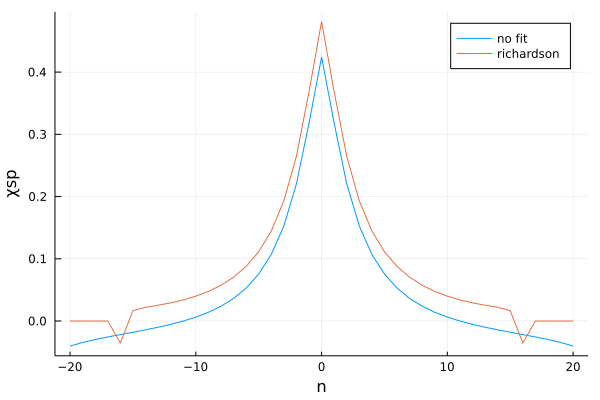

In [119]:
# This shows the q = (pi,pi) spin susceptibility (qG.kGrid contains the k vector for each index)
plot(ωindices .- indh, real(χ_nc[:,end]), label="no fit", ylabel="χsp", xlabel="n")
plot!(ωindices .- indh, real(χ_rc[:,end]), label="richardson")

In [120]:
# prepare data for plots
γ_nc_ων  = real.(kintegrate(qG,γ_nc, dim=2))
γ_rc_ων = real.(kintegrate(qG,γ_rc, dim=2))
γ_mix1_ων = real.(kintegrate(qG,γ_mix1, dim=2))
γ_mix2_ων = real.(kintegrate(qG,γ_mix2, dim=2));
println("maximum imaginary part. naive: $(maximum(imag(γ_nc))), richardson: $(maximum(imag(γ_rc))), mix1: $(maximum(imag(γ_mix1))), mix2: $(maximum(imag(γ_mix2)))")

maximum imaginary part. naive: 0.06942956357552428, richardson: 2158.420315674633, mix1: 2477.584031770889, mix2: 0.44124809697102263


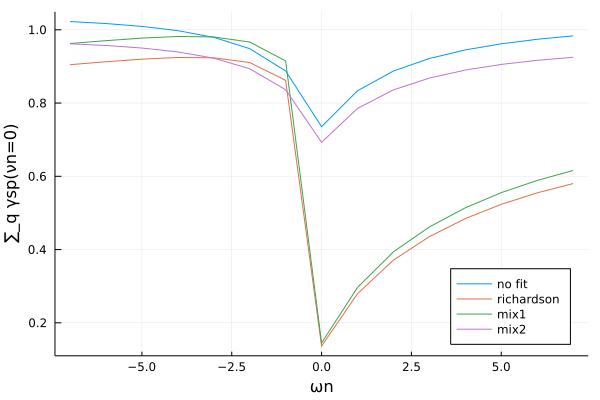

In [125]:
plot(ωindices[usable] .- indh, real(γ_nc_ων[usable,end,indh]), label="no fit", ylabel="∑_q γsp(νn=0)", xlabel="ωn", legend=:bottomright)
plot!(ωindices[usable] .- indh, real(γ_rc_ων[usable,end,indh]), label="richardson")
plot!(ωindices[usable] .- indh, real(γ_mix1_ων[usable,end,indh]), label="mix1")
plot!(ωindices[usable] .- indh, real(γ_mix2_ων[usable,end,indh]), label="mix2")

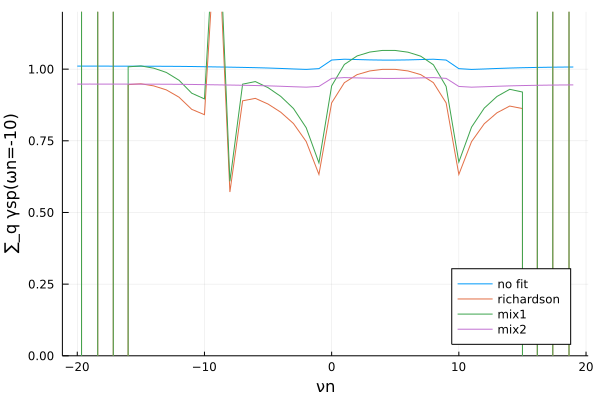

In [145]:
wind = indh-10
plot(νIndices .- indh, real(γ_nc_ων[wind,end,:]), label="no fit", ylabel="∑_q γsp(ωn=$(wind-indh))", xlabel="νn", legend=:bottomright, ylims=(0,1.2))
plot!(νIndices .- indh, real(γ_rc_ων[wind,end,:]), label="richardson")
plot!(νIndices .- indh, real(γ_mix1_ων[wind,end,:]), label="mix1")
plot!(νIndices .- indh, real(γ_mix2_ων[wind,end,:]), label="mix2")